# Data Cleaning and Categorization

This section of the notebook performs data cleaning and categorization on a CSV file containing transaction records. The steps include:

1. Loading the CSV file and splitting it into multiple columns.
2. Dropping unnecessary columns and rows with invalid data.
3. Converting date columns to datetime format.
4. Cleaning and merging specific columns.
5. Removing rows based on specific conditions in the 'Description' column.
6. Categorizing transactions into predefined categories: "Food and Beverage", "Transportation", and "Entertainment".
7. Removing rows that do not fit into any of the predefined categories.
8. Displaying the count of each category and the date range of the transactions.

In [2]:
import pandas as pd

# Load the CSV file
file_path = "./AkbankMevduatEkstre.csv"  # Update this path as needed

# Load the file as a single-column dataset
data = pd.read_csv(file_path, delimiter=';', header=None, on_bad_lines='skip')

# Split the single column into multiple columns based on commas
data = data[0].str.split(',', expand=True)

# Drop specific columns
data = data.drop(columns=[10, 11, 12])  # Drop columns 10, 11, and 12
data = data.drop(columns=[2, 3])        # Drop columns 2 and 3

# Drop rows where the first column is NaN or does not contain a valid date
data = data[data[0].notna()]  # Remove rows with NaN in the first column
data = data[data[0].str.match(r'^\d{2}\.\d{2}\.\d{4}$', na=False)]  # Keep only rows with a valid date pattern

# Reset the index for clean DataFrame
data = data.reset_index(drop=True)

# Convert the first column to datetime format
data[0] = pd.to_datetime(data[0], format='%d.%m.%Y')

for col in [4, 5, 6, 7]:
    data[col] = data[col].astype(str).str.replace('"', '', regex=False)

    # Merge the 4 (integer part) and 5 (decimal part) columns into a single float
    data[4] = data[4].str.replace('.', '', regex=False)
    data[5] = data[5].str.replace('.', '', regex=False)
    data[6] = data[6].str.replace('.', '', regex=False)
    data[7] = data[7].str.replace('.', '', regex=False)


for col in [4, 5, 6, 7]:
    data[col] = data[col].astype(float)

    # Drop the 5th and 7th columns


data = data.drop(columns=[5, 7])

# Drop rows that have 'A' in the 8th column
data = data[data[8] != 'A']

data = data.drop(columns=[8])

# Rename the columns
data.columns = ['Date', 'Time', 'Amount', 'Balance', 'Description']

# Remove numeric values from the 'Description' column
data['Description'] = data['Description'].str.replace(r'\d+', '', regex=True)

# Remove all 'X' characters from the 'Description' column
data['Description'] = data['Description'].str.replace('X', '', regex=False)

# Remove rows that have 'HVL' in the 'Description' column
data = data[~data['Description'].str.contains('HVL', na=False)]

# Remove rows that contain '// TARIHLI BORC TUTARI-DETAY AK' in the 'Description' column
data = data[~data['Description'].str.contains('// TARIHLI BORC TUTARI-DETAY AK', na=False)]

# Remove rows where the 'Description' column starts and ends with '-'
data = data[~data['Description'].str.match(r'^-.*-$', na=False)]

# Remove rows that have 'HAV' in the 'Description' column
data = data[~data['Description'].str.contains('HAV', na=False)]

# Remove rows that contain 'Kredi Kartı Ödeme' in the 'Description' column
data = data[~data['Description'].str.contains('Kredi Kartı Ödeme', na=False)]

# Remove rows that contain 'PARA GÖNDER' in the 'Description' column
data = data[~data['Description'].str.contains('PARA GÖNDER', na=False)]

# Remove rows that contain 'HALKA ARZ' in the 'Description' column
data = data[~data['Description'].str.contains('HALKA ARZ', na=False)]

# Remove rows where the 'Description' column starts with '-'
data = data[~data['Description'].str.startswith('-', na=False)]

# Remove rows that contain 'EFT' in the 'Description' column
data = data[~data['Description'].str.contains('EFT', na=False)]


# Get unique values in the 'Description' column and their counts
unique_descriptions = data['Description'].value_counts()


# Define all keywords for categorization
food_beverage_keywords = [
    "gida", "yemeksepeti", "sabancı", "migros", "self gıda", "kucuk ev", "sok", "kopuklu kahve", 
    "burger", "cafe", "vending", "doyuyo", "kahve", "starbucks", "getir", "restaurant", "simit",
    "market", "sabanci", "sabanc", "atli", "cajun", "şok", "dürüm", "lokanta", "lokantasi", "lokantasi", "coffee", "kebap", "tavuk", "pizza", "burger",
    "kahvalti", "kahvaltı", "fırın", "sb", "bar", "bistro", "çay", "çorb", "çorba", "döner", "dondurma", "dondur", "ekmek", "ekmek", "fast food", "fastfood",
    "kokorec", "yemek", "komagene", "carrefoursa", "mutfak", "makarna", "döner", "kafe", "pasta", "matikotomat", "üniversite"
]

transportation_keywords = [
    "gürsel", "izmirim kart", "belbim", "taxi", "metro", "gür-sel", 
    "otobüs", "tren", "uçak", "havaalanı", "transfer", "transport", "fuel", 
    "otogar", "otopark", "köprü", "taksi", "dolmuş", "turizm", "gur-sel", 
]

# Keywords for entertainment-related entries
entertainment_keywords = [
    "thales", "mobilet", "passo", "şans oyunları", "misli", "beach", "hotel", 
    "foça", "oyun", "mandelas", "netflix", "spotify", "cinema", "movie", "concert",
    "playstation", "game", "amazonprime", "gaming", "theater", "sports"
]

# Update the categorization function to include "Entertainment"
def categorize(description):
    description = description.lower()
    if any(keyword in description for keyword in food_beverage_keywords):
        return "Food and Beverage"
    elif any(keyword in description for keyword in transportation_keywords):
        return "Transportation"
    elif any(keyword in description for keyword in entertainment_keywords):
        return "Entertainment"
    else:
        return "Other"

# Apply the updated categorization function
data['Category'] = data['Description'].apply(categorize)



# Delete rows with 'Other' category
data = data[data['Category'] != 'Other']


# View the updated category counts
print(data['Category'].value_counts())

# Get the range of the dates
date_range = data['Date'].min(), data['Date'].max()
print(f"Date range: {date_range[0]} to {date_range[1]}")


Category
Food and Beverage    1056
Entertainment         370
Transportation         85
Name: count, dtype: int64
Date range: 2023-01-01 00:00:00 to 2024-12-27 00:00:00


## This script processes a DataFrame to identify and flag specific dates based on exam periods and match days.

Functions and operations included:
1. Define exam date ranges and convert them to datetime objects.
2. Define a function `is_final_week` to check if a given date falls within any of the exam date ranges.
3. Add a new column `Is_Final_Week` to the DataFrame to flag dates that fall within the exam periods.
4. Extract unique match days based on the presence of the keyword 'misli' in the 'Description' column.
5. Generate a range of dates for each match day, including the day before and the day after.
6. Add a new column `Is_Match_Day` to the DataFrame to flag dates that fall within the match day ranges.

In [3]:
# Define the exam date ranges
exam_date_ranges = [
    ("2024-01-06", "2024-01-19"),
    ("2024-05-30", "2024-06-09"),
    ("2023-01-07", "2023-01-20"),
    ("2023-06-01", "2023-06-11")
]

# Convert to datetime ranges
exam_date_ranges = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in exam_date_ranges]

# Add a flag for final weeks
def is_final_week(date):
    for start, end in exam_date_ranges:
        if start <= date <= end:
            return True
    return False

data['Is_Final_Week'] = data['Date'].apply(is_final_week)

# Extract match days based on 'misli' keyword
match_days = data[data['Description'].str.contains('misli', case=False)]['Date'].unique()

# Generate match day range (match day + day before and after)
match_date_range = []
for match_day in match_days:
    match_date_range.append(match_day)  # Match day
    match_date_range.append(match_day - pd.Timedelta(days=1))  # Day before
    match_date_range.append(match_day + pd.Timedelta(days=1))  # Day after

# Remove duplicates and sort
match_date_range = sorted(set(match_date_range))

# Add a flag for match days
data['Is_Match_Day'] = data['Date'].isin(match_date_range)

data.head(10)



,Date,Time,Amount,Balance,Description,Category,Is_Final_Week,Is_Match_Day
0,2024-12-27,11:37,129.0,4974.0,İSTANBUL SABANC TEMASSIZ,Food and Beverage,False,False
1,2024-12-26,21:03,310.0,5103.0,YEMEKSEPETIPAY /Yeme,Food and Beverage,False,False
2,2024-12-26,15:45,160.0,5414.0,SELF GIDA SANAYI VE,Food and Beverage,False,False
3,2024-12-26,01:25,210.0,5574.0,ATLI OTOMOTIV,Food and Beverage,False,False
4,2024-12-25,23:04,15.0,5784.0,SELF GIDA SANAYI VE,Food and Beverage,False,False
5,2024-12-24,21:35,503.0,5799.0,YEMEKSEPETIPAY /Yeme,Food and Beverage,False,False
6,2024-12-24,19:06,120.0,6302.0,SELF GIDA SANAYI VE,Food and Beverage,False,False
7,2024-12-24,18:59,59.0,6422.0,İSTANBUL SABANC TEMASSIZ,Food and Beverage,False,False
8,2024-12-24,02:22,30.0,6482.0,ATLI OTOMOTIV,Food and Beverage,False,False
9,2024-12-23,21:55,275.0,6512.0,MONEYPAY/MIGROSONE Y,Food and Beverage,False,False


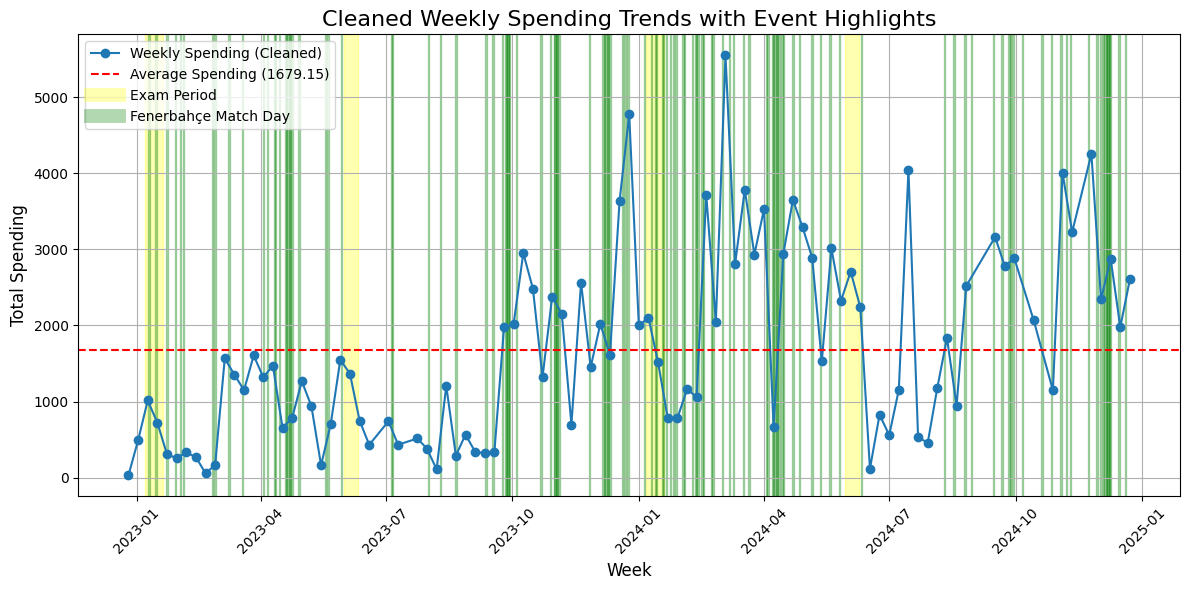

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Date' is a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Add 'Week' and 'Day' columns
data['Week'] = data['Date'].dt.to_period('W').apply(lambda r: r.start_time)  # Weekly start date
data['Day'] = data['Date'].dt.day_name()  # Day of the week

# Calculate weekly spending
weekly_spending = data.groupby('Week')['Amount'].sum().reset_index()

# Calculate average weekly spending
average_weekly_spending = weekly_spending['Amount'].mean()

# Calculate spending by weekdays
weekday_spending = data.groupby('Day')['Amount'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()

# Calculate the IQR for weekly spending
q1 = weekly_spending['Amount'].quantile(0.25)  # First quartile
q3 = weekly_spending['Amount'].quantile(0.75)  # Interquartile range
iqr = q3 - q1  # Interquartile range

# Define the lower and upper bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Drop outliers from the weekly spending data
weekly_spending = weekly_spending[weekly_spending['Amount'] <= upper_bound]

# Define Fenerbahçe's match days
fenerbahce_match_days = [
    "2023-02-27", "2023-04-20", "2023-04-21", "2023-04-22", "2023-04-23",
    "2023-09-26", "2023-09-27", "2023-09-28", "2023-09-29",
    "2023-11-01", "2023-11-02", "2023-11-03", "2023-11-04",
    "2023-12-06", "2023-12-07", "2023-12-08", "2023-12-09",
    "2024-01-18", "2024-02-12", "2024-02-13",
    "2024-04-07", "2024-04-08", "2024-04-09", "2024-04-10", "2024-04-11", "2024-04-12",
    "2024-06-11", "2024-09-26", "2024-09-27",
    "2024-12-04", "2024-12-05", "2024-12-06", "2024-12-07", "2024-12-08", "2024-12-09",
    "2023-01-10", "2023-02-02", "2023-02-04", "2023-03-09", "2023-04-03", "2023-04-06", 
    "2023-04-11", "2023-04-12", "2023-07-05", "2023-07-06", "2023-08-01", "2023-08-10", 
    "2023-09-12", "2023-10-04", "2023-12-10", "2023-12-11", "2023-01-15", "2023-04-15", 
    "2023-09-17", "2023-05-18", "2023-03-19", "2023-04-19", "2023-05-20", "2023-12-20", 
    "2023-08-21", "2023-10-22", "2023-01-23", "2023-04-24", "2023-09-24", "2023-12-24", 
    "2023-02-25", "2023-11-26", "2023-09-28", "2023-01-29", "2023-04-29", "2023-10-29", 
    "2023-05-30", "2023-12-22", "2023-11-01", "2024-02-02", "2024-03-02", "2024-12-02", 
    "2024-02-03", "2024-04-03", "2024-11-03", "2024-01-05", "2024-05-06", "2024-10-06", 
    "2024-12-07", "2024-02-09", "2024-01-10", "2024-03-10", "2024-08-10", "2024-11-10", 
    "2024-02-11", "2024-05-12", "2024-01-13", "2024-01-14", "2024-04-14", "2024-09-15", 
    "2024-12-15", "2024-02-16", "2024-02-17", "2024-03-17", "2024-08-17", "2024-01-19", 
    "2024-05-19", "2024-10-20", "2024-12-20", "2024-01-21", "2024-09-21", "2024-03-21", 
    "2024-04-22", "2024-02-23", "2024-11-23", "2024-01-24", "2024-02-24", "2024-08-25", 
    "2024-01-26", "2024-05-26", "2024-04-27", "2024-10-27", "2024-01-28", "2024-09-29", 
    "2024-11-29", "2024-11-07", "2024-04-15", "2024-04-04", "2024-03-07", "2024-08-30"
]
fenerbahce_match_days = pd.to_datetime(fenerbahce_match_days)

# Line chart for cleaned weekly spending trends
plt.figure(figsize=(12, 6))
plt.plot(weekly_spending['Week'], weekly_spending['Amount'], marker='o', label='Weekly Spending (Cleaned)')
plt.axhline(weekly_spending['Amount'].mean(), color='red', linestyle='--', label=f'Average Spending ({weekly_spending["Amount"].mean():.2f})')

# Highlight exam periods
for start, end in exam_date_ranges:
    plt.axvspan(start, end, color='yellow', alpha=0.3)

# Highlight Fenerbahçe's match days
for match_day in fenerbahce_match_days:
    plt.axvspan(match_day - pd.Timedelta(days=0.5), match_day + pd.Timedelta(days=0.5), color='green', alpha=0.3)

# Add legend entries for exam periods and Fenerbahçe's match days
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='yellow', alpha=0.3, linewidth=10))
labels.append('Exam Period')
handles.append(plt.Line2D([0], [0], color='green', alpha=0.3, linewidth=10))
labels.append('Fenerbahçe Match Day')
plt.legend(handles=handles, labels=labels)

plt.title('Cleaned Weekly Spending Trends with Event Highlights', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_69785/123572633.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Day', y='Amount', data=cleaned_weekday_spending, palette='Blues_d')


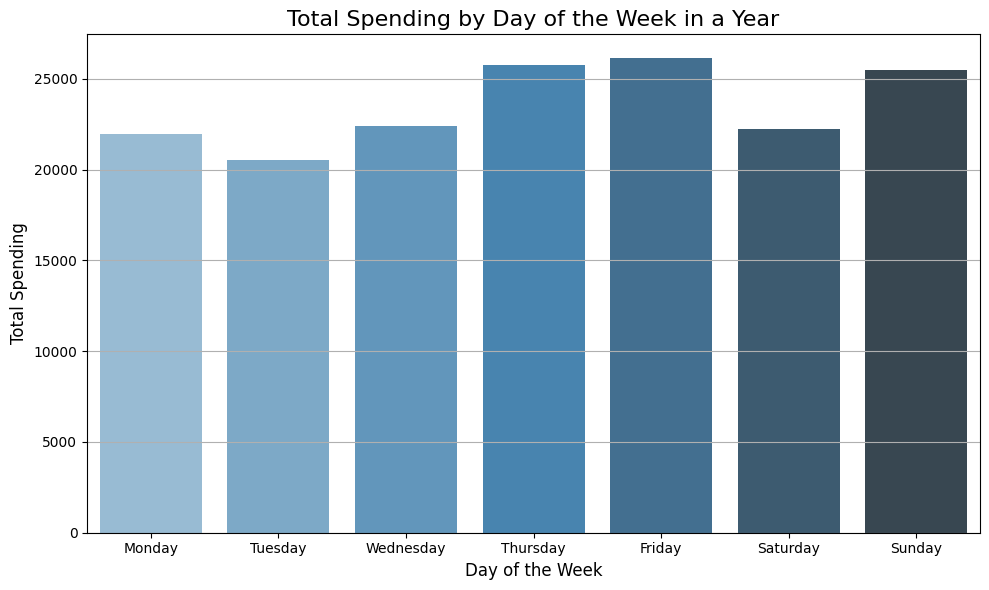

In [5]:
# Recalculate weekday spending based on the cleaned data
cleaned_weekday_spending = data[data['Date'].dt.to_period('W').apply(lambda r: r.start_time).isin(weekly_spending['Week'])]
cleaned_weekday_spending = cleaned_weekday_spending.groupby('Day')['Amount'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()

# Bar chart for weekday spending trends using cleaned data
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='Amount', data=cleaned_weekday_spending, palette='Blues_d')
plt.title('Total Spending by Day of the Week in a Year', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_69785/548571289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Month'] = cleaned_data['Date'].dt.to_period('M').apply(lambda r: r.start_time)


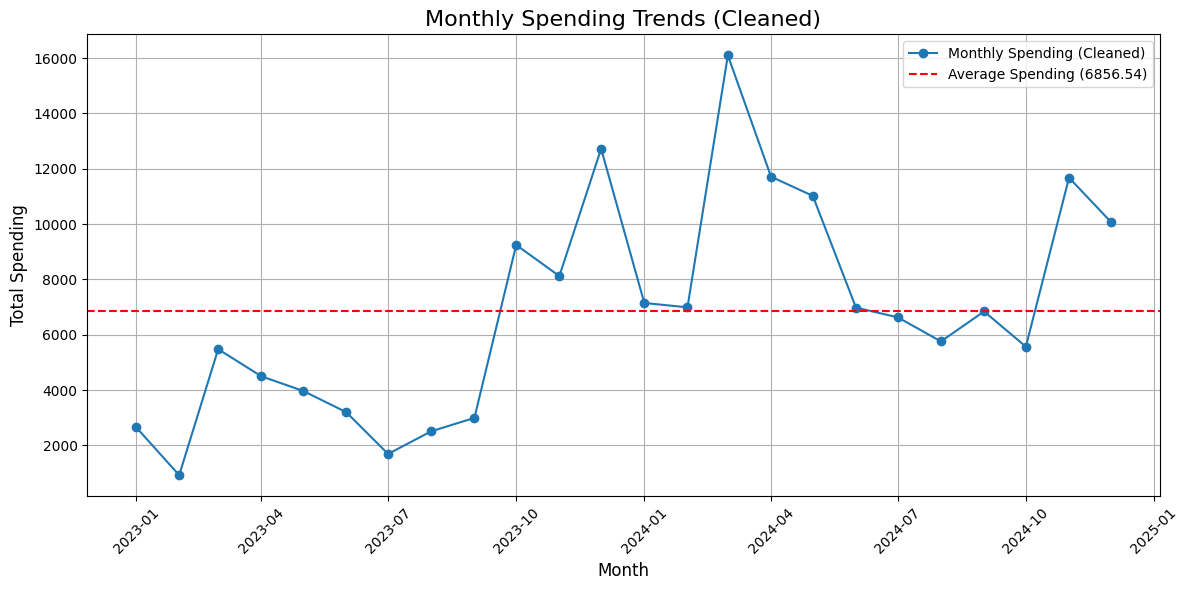

In [6]:
# Add a 'Month' column to the cleaned data
cleaned_data = data[data['Date'].dt.to_period('W').apply(lambda r: r.start_time).isin(weekly_spending['Week'])]
cleaned_data['Month'] = cleaned_data['Date'].dt.to_period('M').apply(lambda r: r.start_time)

# Calculate monthly spending based on the cleaned data
monthly_spending_cleaned = cleaned_data.groupby('Month')['Amount'].sum().reset_index()

# Calculate average monthly spending
average_monthly_spending_cleaned = monthly_spending_cleaned['Amount'].mean()

# Line chart for monthly spending trends (cleaned data)
plt.figure(figsize=(12, 6))
plt.plot(monthly_spending_cleaned['Month'], monthly_spending_cleaned['Amount'], marker='o', label='Monthly Spending (Cleaned)')
plt.axhline(average_monthly_spending_cleaned, color='red', linestyle='--', label=f'Average Spending ({average_monthly_spending_cleaned:.2f})')
plt.title('Monthly Spending Trends (Cleaned)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_69785/158970107.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Season'] = cleaned_data['Date'].apply(get_season)
/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_69785/158970107.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Quarter'] = cleaned_data['Date'].dt.quarter
/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_69785/158970107.py:27: FutureWarning: 

Passing `palette` without assigning

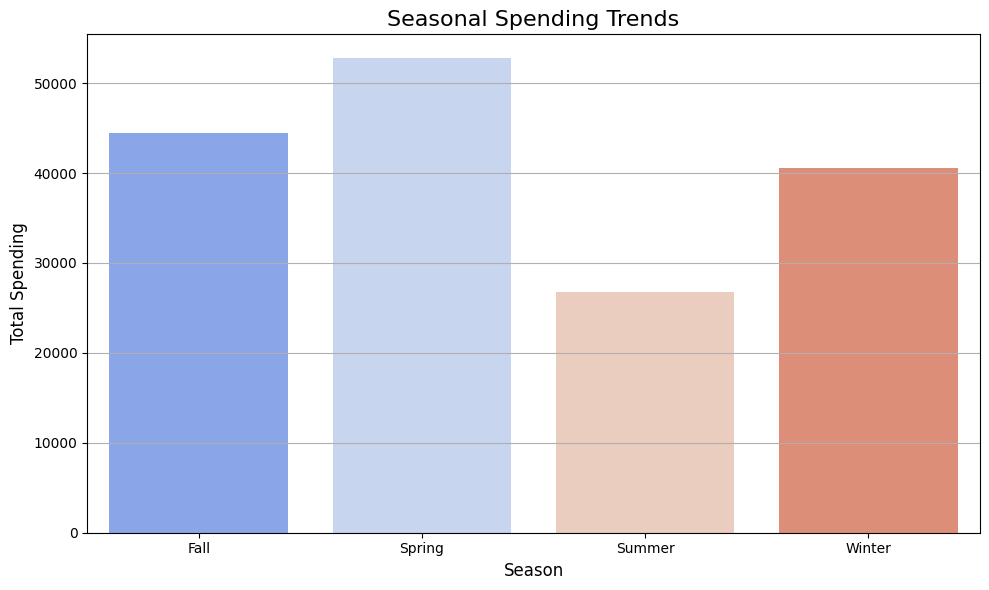

In [7]:
# Filter cleaned data
cleaned_data = data[data['Date'].dt.to_period('W').apply(lambda r: r.start_time).isin(weekly_spending['Week'])]

# Add 'Season' and 'Quarter' columns
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

cleaned_data['Season'] = cleaned_data['Date'].apply(get_season)
cleaned_data['Quarter'] = cleaned_data['Date'].dt.quarter

# Aggregate spending by season
seasonal_spending = cleaned_data.groupby('Season')['Amount'].sum().reset_index()

# Aggregate spending by quarter
quarterly_spending = cleaned_data.groupby('Quarter')['Amount'].sum().reset_index()

# Bar chart for seasonal spending
plt.figure(figsize=(10, 6))
sns.barplot(x='Season', y='Amount', data=seasonal_spending, palette='coolwarm')
plt.title('Seasonal Spending Trends', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_69785/709897126.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'], errors='coerce')
/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_69785/709897126.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Month'] = cleaned_data['Date'].dt.strftime('%B')


Columns in DataFrame: Index(['Date', 'Time', 'Amount', 'Balance', 'Description', 'Category',
       'Is_Final_Week', 'Is_Match_Day', 'Week', 'Day', 'Season', 'Quarter'],
      dtype='object')


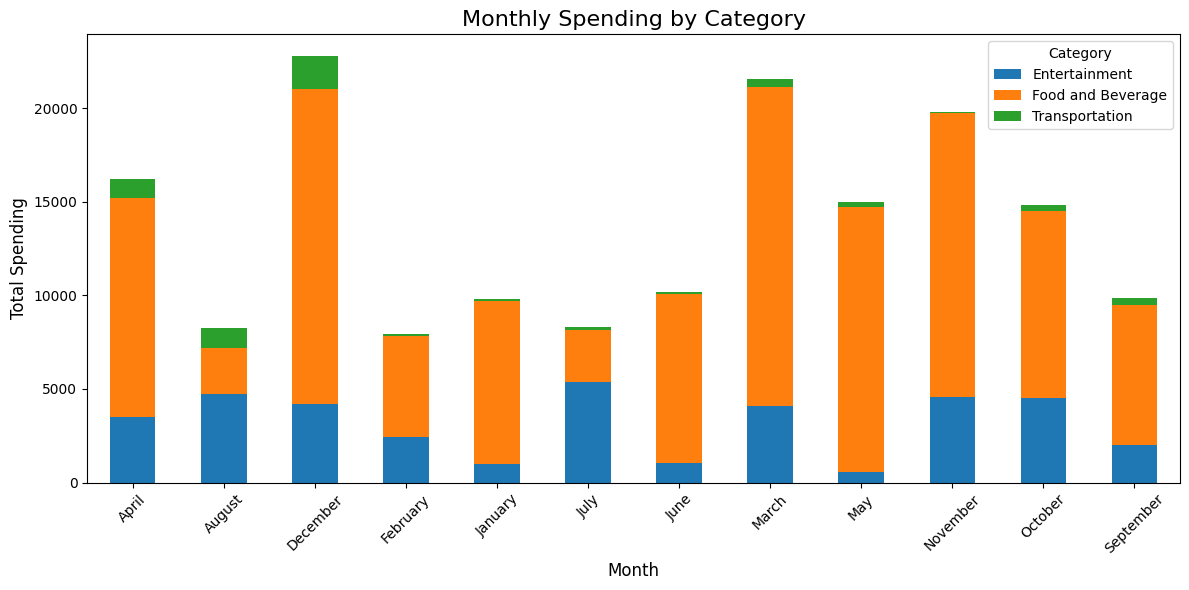

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'cleaned_data' is your DataFrame, ensure it has the correct columns
# Check the columns in the DataFrame
print("Columns in DataFrame:", cleaned_data.columns)

# Ensure 'Month' column exists; create it if necessary
if 'Month' not in cleaned_data.columns:
    if 'Date' in cleaned_data.columns:
        # Ensure 'Date' is in datetime format
        cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'], errors='coerce')
        # Extract month name from 'Date'
        cleaned_data['Month'] = cleaned_data['Date'].dt.strftime('%B')
    else:
        raise KeyError("Neither 'Month' nor 'Date' column exists in the DataFrame.")

# Ensure 'Category' and 'Amount' columns exist
required_columns = ['Month', 'Category', 'Amount']
for col in required_columns:
    if col not in cleaned_data.columns:
        raise KeyError(f"Column '{col}' does not exist in the DataFrame.")

# Check for missing values and handle them
if cleaned_data[required_columns].isnull().any().any():
    print("Missing values found in critical columns. Dropping rows with missing values.")
    cleaned_data = cleaned_data.dropna(subset=required_columns)

# Aggregate spending by category and month
category_monthly_spending = cleaned_data.groupby(['Month', 'Category'])['Amount'].sum().unstack().fillna(0)

# Plot stacked bar chart for spending distribution by category
category_monthly_spending.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Monthly Spending by Category', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

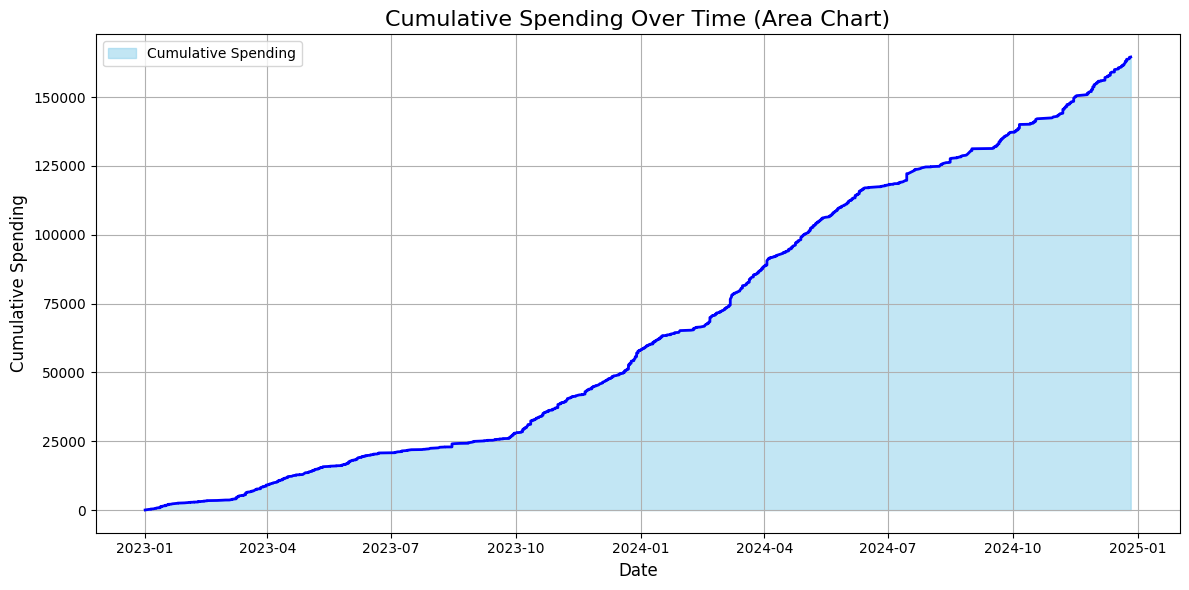

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the necessary column exists by calculating cumulative spending
if 'Cumulative_Spending' not in cleaned_data.columns:
    # Ensure 'Amount' column exists for calculation
    if 'Amount' not in cleaned_data.columns:
        raise KeyError("'Amount' column is required to calculate cumulative spending.")
    
    # Sort data by 'Date' if necessary
    if 'Date' in cleaned_data.columns:
        cleaned_data = cleaned_data.sort_values(by='Date')
    else:
        raise KeyError("'Date' column is required to plot cumulative spending over time.")
    
    # Calculate cumulative spending
    cleaned_data['Cumulative_Spending'] = cleaned_data['Amount'].cumsum()

# Plot the area chart for cumulative spending over time
plt.figure(figsize=(12, 6))
plt.fill_between(cleaned_data['Date'], cleaned_data['Cumulative_Spending'], color='skyblue', alpha=0.5, label='Cumulative Spending')
plt.plot(cleaned_data['Date'], cleaned_data['Cumulative_Spending'], color='blue', linewidth=2)
plt.title('Cumulative Spending Over Time (Area Chart)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Spending', fontsize=12)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_69785/1969357917.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Amount', data=average_transaction_spending, palette='Set2')


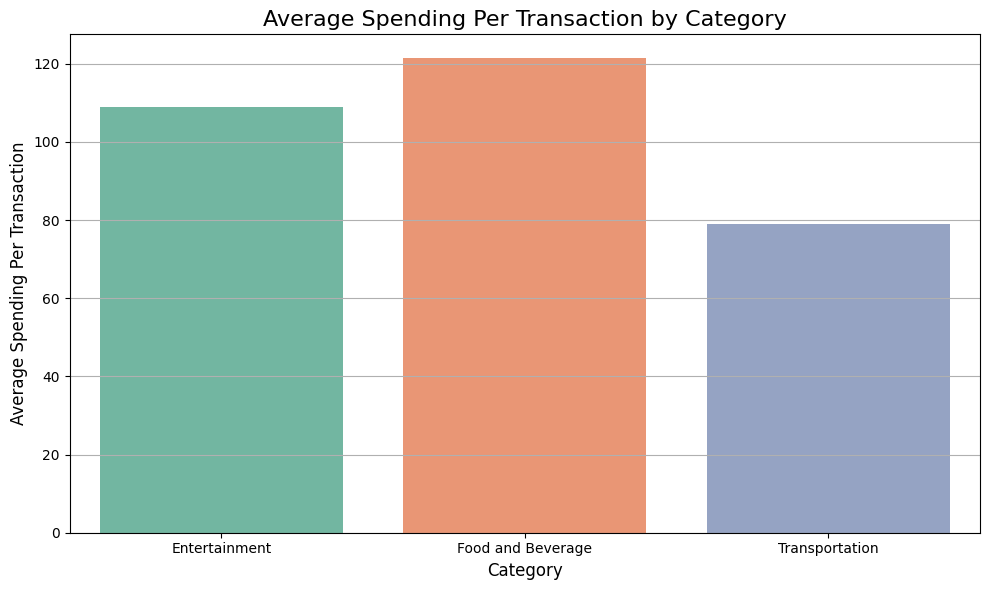

In [10]:
# Calculate average spending per transaction for each category
average_transaction_spending = cleaned_data.groupby('Category')['Amount'].mean().reset_index()

# Plot bar chart for average spending per transaction
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Amount', data=average_transaction_spending, palette='Set2')
plt.title('Average Spending Per Transaction by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Spending Per Transaction', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

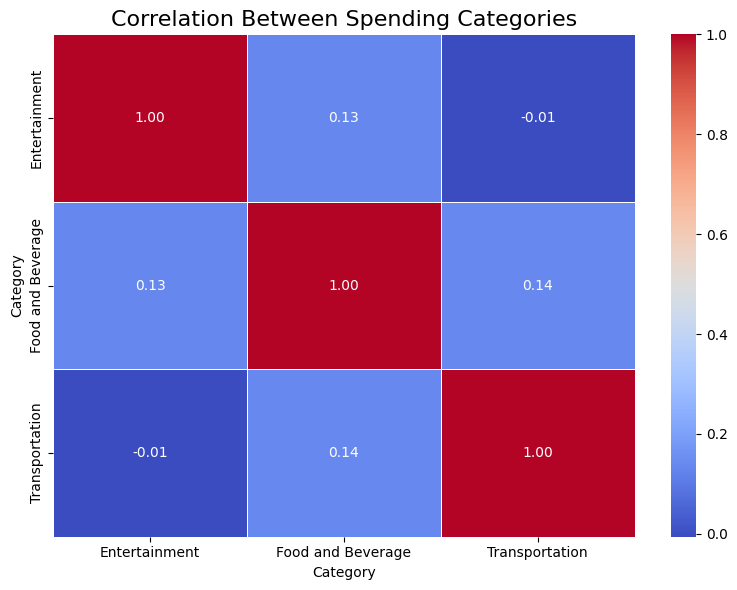

In [11]:
# Pivot data for correlation analysis
category_weekly_spending = cleaned_data.pivot_table(index='Week', columns='Category', values='Amount', aggfunc='sum').fillna(0)

# Calculate correlation matrix
correlation_matrix = category_weekly_spending.corr()

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Spending Categories', fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

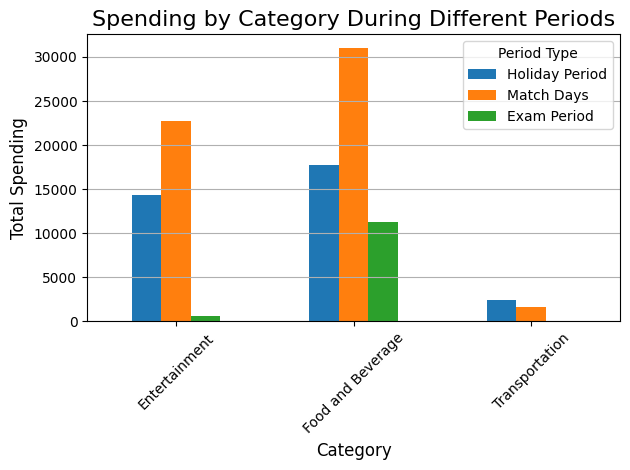

<Figure size 1200x600 with 0 Axes>

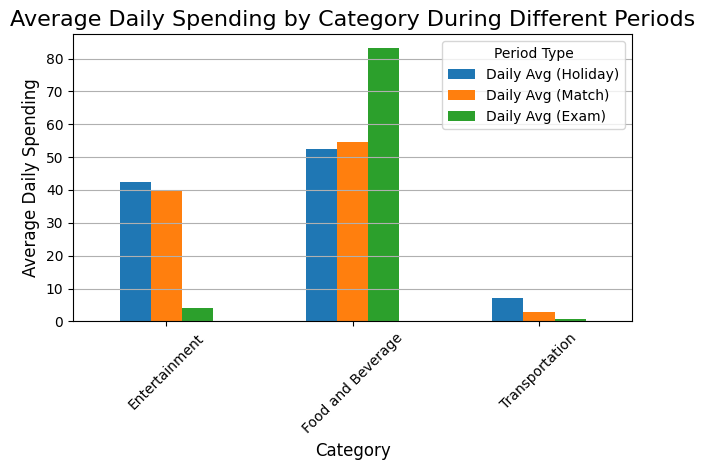


Spending Comparison by Category:
                   Holiday Period  Match Days  Exam Period  \
Category                                                     
Entertainment             14315.0     22734.0        556.0   
Food and Beverage         17759.0     31017.0      11235.0   
Transportation             2411.0      1681.0         83.0   

                   Daily Avg (Holiday)  Daily Avg (Match)  Daily Avg (Exam)  
Category                                                                     
Entertainment                    42.35              39.95              4.12  
Food and Beverage                52.54              54.51             83.22  
Transportation                    7.13               2.95              0.61  


In [12]:
# Define the holiday date ranges
holiday_date_ranges = [
    ("2023-01-18", "2023-02-27"),
    ("2023-04-20", "2023-04-24"),
    ("2023-06-11", "2023-09-26"),
    ("2024-01-18", "2024-02-13"),
    ("2024-04-07", "2024-04-12"),
    ("2024-06-11", "2024-09-27"),
    ("2024-12-04", "2024-12-09")
]

# Convert to datetime ranges
holiday_date_ranges = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in holiday_date_ranges]

# Add a flag for holidays
def is_holiday(date):
    for start, end in holiday_date_ranges:
        if start <= date <= end:
            return True
    return False

cleaned_data['Is_Holiday'] = cleaned_data['Date'].apply(is_holiday)


# Calculate spending by category for each period type
holiday_spending = cleaned_data[cleaned_data['Is_Holiday']].groupby('Category')['Amount'].sum()
match_day_spending = cleaned_data[cleaned_data['Is_Match_Day']].groupby('Category')['Amount'].sum()
exam_spending = cleaned_data[cleaned_data['Is_Final_Week']].groupby('Category')['Amount'].sum()

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Holiday Period': holiday_spending,
    'Match Days': match_day_spending,
    'Exam Period': exam_spending
}).fillna(0)

# Calculate averages per day for each period
holiday_days = cleaned_data['Is_Holiday'].sum()
match_days = cleaned_data['Is_Match_Day'].sum()
exam_days = cleaned_data['Is_Final_Week'].sum()

comparison_df['Daily Avg (Holiday)'] = comparison_df['Holiday Period'] / holiday_days
comparison_df['Daily Avg (Match)'] = comparison_df['Match Days'] / match_days
comparison_df['Daily Avg (Exam)'] = comparison_df['Exam Period'] / exam_days

# Plot the comparison
plt.figure(figsize=(12, 6))
comparison_df[['Holiday Period', 'Match Days', 'Exam Period']].plot(kind='bar')
plt.title('Spending by Category During Different Periods', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Period Type')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot daily averages
plt.figure(figsize=(12, 6))
comparison_df[['Daily Avg (Holiday)', 'Daily Avg (Match)', 'Daily Avg (Exam)']].plot(kind='bar')
plt.title('Average Daily Spending by Category During Different Periods', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Daily Spending', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Period Type')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print the comparison table
print("\nSpending Comparison by Category:")
print(comparison_df.round(2))

In [13]:
# Group by 'Category' and sum the 'Amount' to find the total spending for each category
total_spending_by_category = cleaned_data.groupby('Category')['Amount'].sum().reset_index()

# Find the category with the highest spending
prominent_spending_group = total_spending_by_category.loc[total_spending_by_category['Amount'].idxmax()]

print("Prominent Spending Group:")
print(prominent_spending_group)
# Calculate the prominent spending group for each period type
periods = ['Holiday Period', 'Match Days', 'Exam Period']
prominent_spending_groups = {}

for period in periods:
    prominent_spending_groups[period] = comparison_df[period].idxmax()

print("Prominent Spending Groups for Each Period:")
for period, category in prominent_spending_groups.items():
    print(f"{period}: {category}")

Prominent Spending Group:
Category    Food and Beverage
Amount               120603.0
Name: 1, dtype: object
Prominent Spending Groups for Each Period:
Holiday Period: Food and Beverage
Match Days: Food and Beverage
Exam Period: Food and Beverage


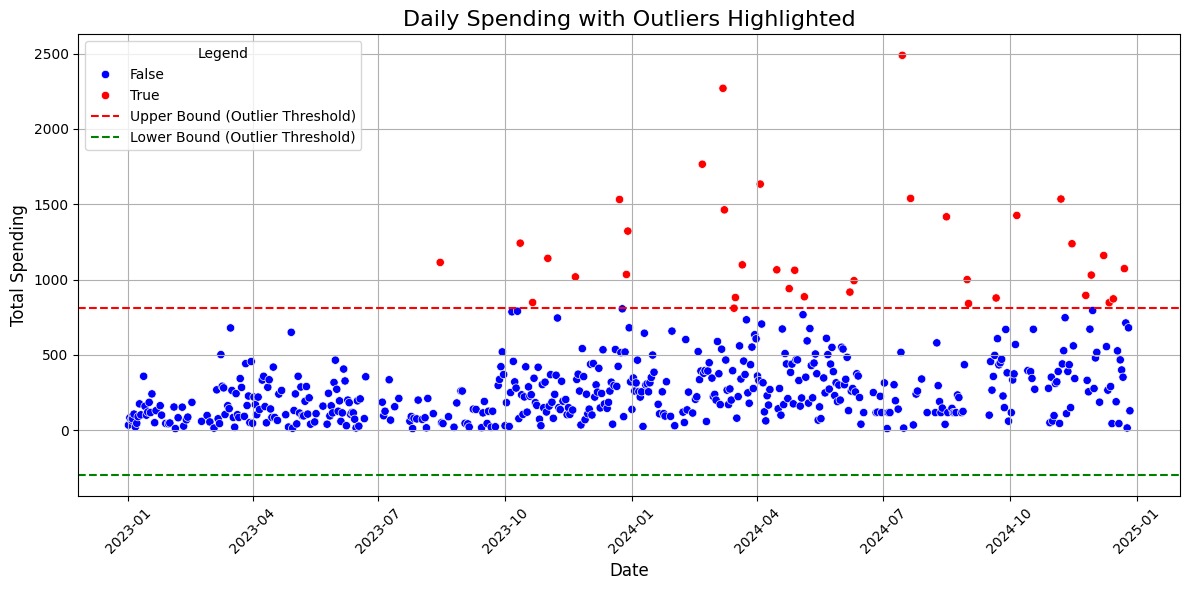

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate daily spending
daily_spending = cleaned_data.groupby('Date')['Amount'].sum().reset_index()

# Calculate IQR for daily spending
q1 = daily_spending['Amount'].quantile(0.25)  # First quartile
q3 = daily_spending['Amount'].quantile(0.75)  # Third quartile
iqr = q3 - q1  # Interquartile range

# Define outlier thresholds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Flag outlier days
daily_spending['Is_Outlier'] = (daily_spending['Amount'] > upper_bound) | (daily_spending['Amount'] < lower_bound)

# Plot daily spending with outliers highlighted
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Date', y='Amount', data=daily_spending, hue='Is_Outlier', palette={True: 'red', False: 'blue'}, legend='full'
)
plt.axhline(upper_bound, color='red', linestyle='--', label='Upper Bound (Outlier Threshold)')
plt.axhline(lower_bound, color='green', linestyle='--', label='Lower Bound (Outlier Threshold)')
plt.title('Daily Spending with Outliers Highlighted', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Legend')
plt.tight_layout()
plt.grid()
plt.show()

/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_69785/345702718.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Period', y='Average Spending', data=average_spending_df, palette='viridis')


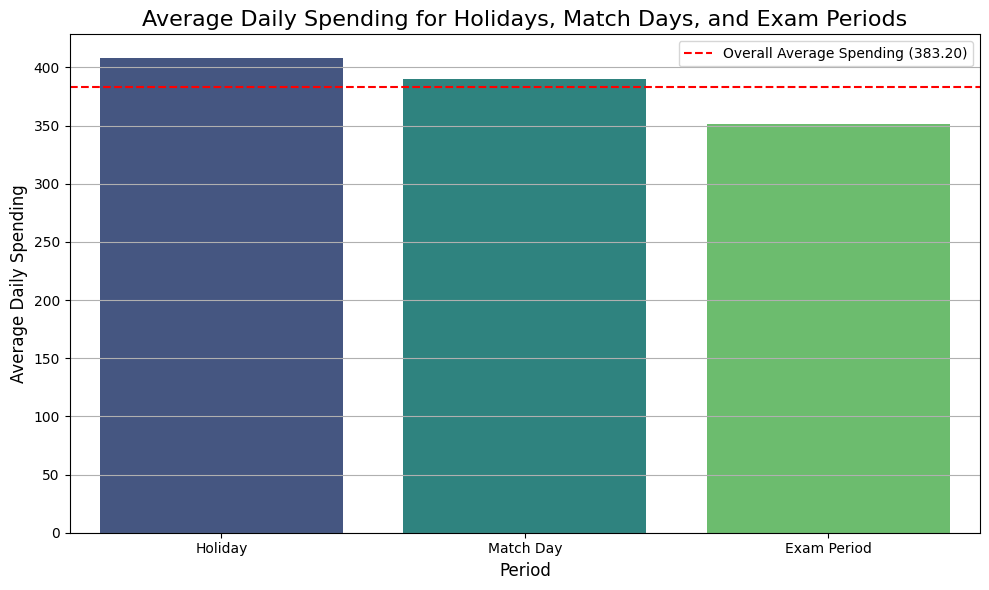

In [15]:
# Calculate daily average spending for each period
average_spending_df = pd.DataFrame({
    'Period': ['Holiday', 'Match Day', 'Exam Period'],
    'Average Spending': [
        comparison_df['Holiday Period'].sum() / holiday_days,
        comparison_df['Match Days'].sum() / match_days,
        comparison_df['Exam Period'].sum() / exam_days
    ]
})

# Multiply each average spending by 4
average_spending_df['Average Spending'] *= 4

# Plot the average spendings
plt.figure(figsize=(10, 6))
sns.barplot(x='Period', y='Average Spending', data=average_spending_df, palette='viridis')

# Add the overall average spending as a line
overall_avg_spending = average_spending_df['Average Spending'].mean()
plt.axhline(overall_avg_spending, color='red', linestyle='--', label=f'Overall Average Spending ({overall_avg_spending:.2f})')

plt.title('Average Daily Spending for Holidays, Match Days, and Exam Periods', fontsize=16)
plt.xlabel('Period', fontsize=12)
plt.ylabel('Average Daily Spending', fontsize=12)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()


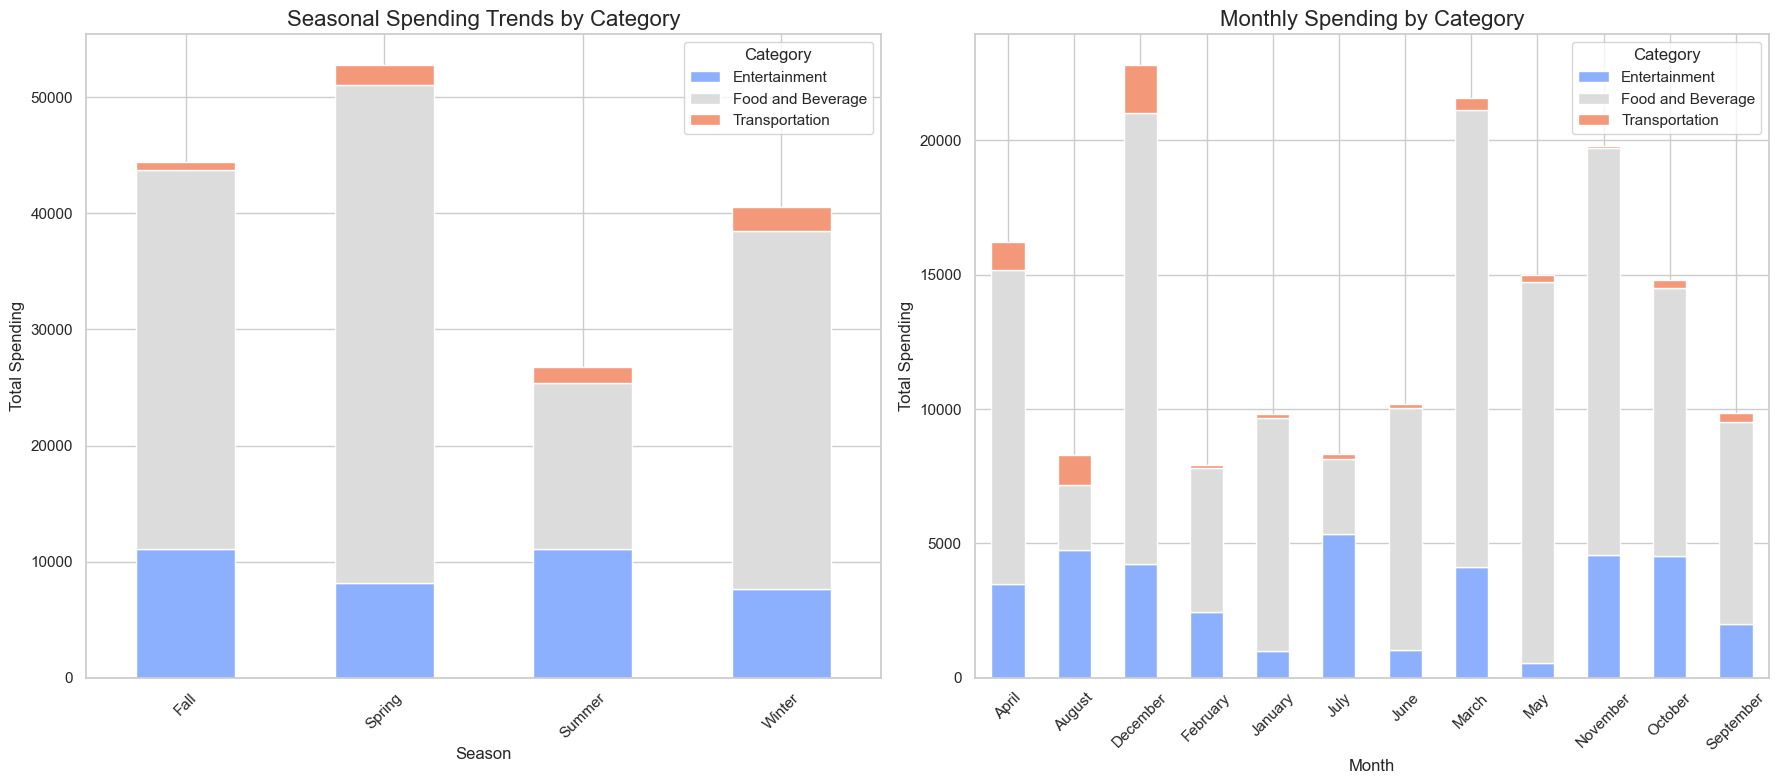

In [18]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style and color palette
sns.set(style="whitegrid")
colors = sns.color_palette("coolwarm", n_colors=3)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot stacked bar chart for seasonal spending by category
seasonal_category_spending.plot(kind='bar', stacked=True, ax=axes[0], color=colors)
axes[0].set_title('Seasonal Spending Trends by Category', fontsize=16)
axes[0].set_xlabel('Season', fontsize=12)
axes[0].set_ylabel('Total Spending', fontsize=12)
axes[0].legend(title='Category')
axes[0].tick_params(axis='x', rotation=45)

# Plot stacked bar chart for monthly spending by category
category_monthly_spending.plot(kind='bar', stacked=True, ax=axes[1], color=colors)
axes[1].set_title('Monthly Spending by Category', fontsize=16)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Total Spending', fontsize=12)
axes[1].legend(title='Category')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()